[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/binder_colab_testing?labpath=%2Fnotebooks%2Fcellml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/cellml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple CellML example


This notebook creates a simple model in [CellML version 2](https://www.cellml.org/specifications/cellml_2.0/cellml_2_0_normative_specification.pdf) for illustration.  It is based on the libCellML tutorial series which can found [here](https://libcellml.org/documentation/v0.4.0/user/tutorials/index).

## 1) Including libraries and helper functions

In [84]:
import importlib.util
from libcellml import Analyser, Component, Model, Printer, Units, Validator, Variable, Generator, GeneratorProfile
import matplotlib.pyplot as plt

from combine_notebooks.cellml_utilities import print_model, print_issues
from combine_notebooks import RESULTS_DIR

In [85]:
def pretty_print(model_before : Model, model_after : Model = None):
    # Break the original CellML into lines
    printer = Printer()
    original_model = printer.printModel(model_before)
    original_model_lines = original_model.split('\n')
    # Print the entire model in red
    if model_after == None:
        original_document = '\n'.join(original_model_lines)
        print("\x1b[31m" + original_document + "\x1b[0m") # ANSI escape used to print colours here
    # If a new model is also given, highlight the lines that have changed
    else:
        # Split the updated CellML into lines
        new_model = printer.printModel(model_after)
        new_model_lines = new_model.split('\n')
        # Iterate over each new line
        for new_line in new_model_lines:
            # Print any new lines in red, otherwise print normally
            if new_line in original_model_lines:
                print(new_line)
            else:
                print("\x1b[31m" + new_line + "\x1b[0m") # ANSI escape used to print colours here

## 2) Declaring the CellML model

The first step is to create a Model item which will later contain the component and the units it needs.

In [86]:
model = Model()

pretty_print(model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#"/>



Each CellML element must have a name, which is set using the setName() function.

In [87]:
start_model = model.clone()

model.setName('tutorial_model')
model.setId('tutorial_model_id_is_here')

pretty_print(start_model, model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here"/>



Now create units for our model, these could be any measure (e.g. grams, liters, miles per hour).  The variables we define later on will be simple quantites, so we need to define a simple "quantity" or "number" units.

In [88]:
start_model = model.clone()

unit1 = Units("number")
model.addUnits(unit1)

unit2 = Units()
unit2.setName("per_number")
unit2.addUnit("number", -1)
model.addUnits(unit2)

pretty_print(start_model, model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here">
  <units name="number"/>
  <units name="per_number">
    <unit exponent="-1" units="number"/>
  </units>
</model>



We'll create a wrapper component whose only job is to encapsulate the other components. This makes is a lot easier for this model to be reused, as the connections between components internal to this one won't need to be re-established. Note that the constructor for all named CellML entities is overloaded, so you can pass it the name string at the time of creation.

In [89]:
component = Component()
component.setName("cancer_cells_component")
component.setId('my_component_id')

Finally we need to add the component to the model.  This sets it at the top-level of 
the components' encapsulation hierarchy.  All other components need to be added 
to this component, rather than the model.

In [90]:
start_model = model.clone()

model.addComponent(component)

pretty_print(start_model, model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here">
  <units name="number"/>
  <units name="per_number">
    <unit exponent="-1" units="number"/>
  </units>
  <component name="cancer_cells_component" id="my_component_id"/>
</model>



 In order to actually model anything, we need to include the mathematical equations which represent the physical situation of interest.  To do this we will start by creating the variables $x$, $y$, and $c$.

In [91]:
start_model = model.clone()

x = Variable("rounds_of_cell_division")
x.setUnits(unit1)
component.addVariable(x)

y = Variable("total_cancer_cells")
y.setUnits(unit1)
component.addVariable(y)

c = Variable("c")
c.setUnits(unit2)
component.addVariable(c)

pretty_print(start_model, model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here">
  <units name="number"/>
  <units name="per_number">
    <unit exponent="-1" units="number"/>
  </units>
  <component name="cancer_cells_component" id="my_component_id">
    <variable name="rounds_of_cell_division" units="number"/>
    <variable name="total_cancer_cells" units="number"/>
    <variable name="c" units="per_number"/>
  </component>
</model>



Equations are modelled using MathML2 strings.  Here we are create MathML to model the simple differential equation 

$$\frac{dy}{dx} = c x$$

where $x$ is time, $y$ is the total number of cancer cells, and $c$ is a constant.  If we were to intergrate this we would get

$$y = \frac{c x ^ 2}{2}$$

In [92]:
# Add the header and footer strings.
math_header = '<math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">'
math_footer = '</math>'

# Create the MathML2 string representing the governing equations.  
equation1 = \
    "  <apply><eq/>"\
    "    <apply><diff/>"\
    "      <bvar><ci>total_cancer_cells</ci></bvar>"\
    "      <ci>rounds_of_cell_division</ci>"\
    "    </apply>"\
    "    <apply><times/>"\
    "      <ci>c</ci>"\
    "      <ci>rounds_of_cell_division</ci>"\
    "    </apply>"\
    "  </apply>"

Include the MathML strings in the component.

In [93]:
start_model = model.clone()

component.setMath(math_header)
component.appendMath(equation1)
component.appendMath(math_footer)

pretty_print(start_model, model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here">
  <units name="number"/>
  <units name="per_number">
    <unit exponent="-1" units="number"/>
  </units>
  <component name="cancer_cells_component" id="my_component_id">
    <variable name="rounds_of_cell_division" units="number"/>
    <variable name="total_cancer_cells" units="number"/>
    <variable name="c" units="per_number"/>
    <math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">
      <apply>
        <eq/>
        <apply>
          <diff/>
          <bvar>
            <ci>total_cancer_cells</ci>
          </bvar>
          <ci>rounds_of_cell_division</ci>
        </apply>
        <apply>
          <times/>
          <ci>c</ci>
          <ci>rounds_of_cell_division</ci>
        </apply>
      </apply>
    </math>
  </component>
</model>



## 3) Write, print and validate the generated model

Print the model to using the print_model helper function and 
check it is what you'd expect.

In [94]:
print_model(model)

MODEL: 'tutorial_model', id: 'tutorial_model_id_is_here'
    UNITS: 2 custom units
        [0]: number
        [1]: per_number
    COMPONENTS: 1 components
        [0]: 'cancer_cells_component', id: 'my_component_id'
            VARIABLES: 3 variables
                [0]: rounds_of_cell_division [number]
                [1]: total_cancer_cells [number]
                [2]: c [per_number]


Create a validator and use it to check the model for issues.

In [95]:
validator = Validator()
validator.validateModel(model)
print_issues(validator)

Recorded 0 issues!



Save the model to a .cellml file and print the raw cellml text.

In [96]:
printer = Printer()
serialised_model = printer.printModel(model)
# Write the serialised string to a file.
file_loc = str(RESULTS_DIR) + "/hello_world_cellml.cellml"

write_file = open(file_loc, "w")
write_file.write(serialised_model)
write_file.close()
print(serialised_model)

<?xml version="1.0" encoding="UTF-8"?>
<model xmlns="http://www.cellml.org/cellml/2.0#" name="tutorial_model" id="tutorial_model_id_is_here">
  <units name="number"/>
  <units name="per_number">
    <unit exponent="-1" units="number"/>
  </units>
  <component name="cancer_cells_component" id="my_component_id">
    <variable name="rounds_of_cell_division" units="number"/>
    <variable name="total_cancer_cells" units="number"/>
    <variable name="c" units="per_number"/>
    <math xmlns="http://www.w3.org/1998/Math/MathML" xmlns:cellml="http://www.cellml.org/cellml/2.0#">
      <apply>
        <eq/>
        <apply>
          <diff/>
          <bvar>
            <ci>total_cancer_cells</ci>
          </bvar>
          <ci>rounds_of_cell_division</ci>
        </apply>
        <apply>
          <times/>
          <ci>c</ci>
          <ci>rounds_of_cell_division</ci>
        </apply>
      </apply>
    </math>
  </component>
</model>



## 4) Simulating the model

Now we will simulate our model using the libCellML library.  First, we create an `Analyser` object and use it to set the inital values of our variables.

In [97]:
analyser = Analyser()
analyser.analyseModel(model)

x.setInitialValue(1)
c.setInitialValue(1)

analyser.analyseModel(model)

The next step is to use our CellML model to generate Python code.  This code, saved in the "exponential.py" file, can then be used to run our simulation.

In [98]:
generator = Generator()
generator.setModel(analyser.model())

profile = GeneratorProfile(GeneratorProfile.Profile.PYTHON)
generator.setProfile(profile)

implementation_code_python = generator.implementationCode()
with open("exponential.py", "w") as f:
    f.write(implementation_code_python)


Finally, we must load the python file we just created, initalize variables in the simulation, and then run the simulation.  Running the simulation itself is done by iterating over 10 time steps and executing `compute_rates` for each time step.  Outputs can then be saved into simple python lists and then plotted.

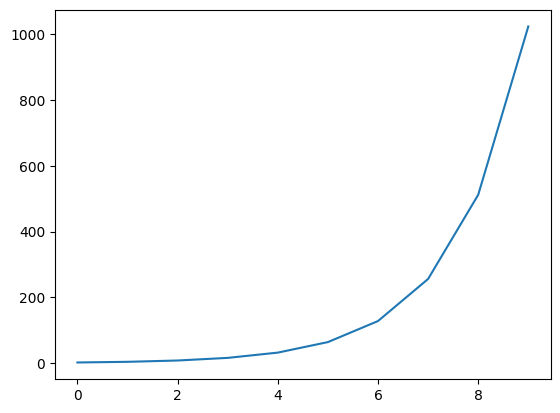

In [99]:
# Use the importlib functionality to open the generated code file.
spec = importlib.util.spec_from_file_location('exponential', 'exponential.py')
model = importlib.util.module_from_spec(spec)

# Load module.
spec.loader.exec_module(model)

my_variables = model.create_variables_array()
my_state_variables = model.create_states_array()
my_rates = model.create_states_array()
division_number = 0.0

# Use the functions provided to initialise the arrays you created
model.initialise_variables(my_state_variables, my_variables)

# Create variables which control how the solution will run, representing the step size and 
# the number of steps to take.
step_size = 1
step_count = 10

cancer_cells = []
divisions = []
for step in range(0, step_count):
    division_number = step * step_size

    # Compute the rates at this step using the given function.
    model.compute_rates(division_number, my_state_variables, my_rates, my_variables)

    # Compute the states.
    for s in range(0, model.STATE_COUNT):
        my_state_variables[s] = my_state_variables[s] + my_rates[s] * step_size

    # A results to a list
    divisions.append(division_number)
    cancer_cells.append(my_state_variables[0])

plt.plot(divisions, cancer_cells)
